In [1]:
%load_ext watermark
%watermark -p torch,torchtext,spacy,pytorch_lightning,torchmetrics,matplotlib

torch            : 1.10.1
torchtext        : 0.11.2
spacy            : 3.2.1
pytorch_lightning: 1.5.9
torchmetrics     : 0.7.0
matplotlib       : 3.5.1



In [2]:
#%load_ext pycodestyle_magic
#%flake8_on --ignore W291,W293

<a href="https://pytorch.org"><img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.svg" width="90"/></a> &nbsp; &nbsp;&nbsp;&nbsp;<a href="https://www.pytorchlightning.ai"><img src="https://raw.githubusercontent.com/PyTorchLightning/pytorch-lightning/master/docs/source/_static/images/logo.svg" width="150"/></a>

# A Recurrent Neural Net for Ordinal Regression using CORAL -- TripAdvisor Dataset

In this tutorial, we implement a recurrent neural network for ordinal regression based on the CORAL method. To learn more about CORAL, please have a look at our paper:

- Wenzhi Cao, Vahid Mirjalili, and Sebastian Raschka (2020): 
[Rank Consistent Ordinal Regression for Neural Networks with Application to Age Estimation](https://www.sciencedirect.com/science/article/pii/S016786552030413X). 
Pattern Recognition Letters. 140, 325-331

We will be using a balanced version of the [TripAdvisor Hotel Review](https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews) dataset that [we used](https://github.com/Raschka-research-group/corn-ordinal-neuralnet/blob/main/datasets/tripadvisor/tripadvisor_balanced.csv) in the CORN manuscript.

## General settings and hyperparameters

- Here, we specify some general hyperparameter values and general settings
- Note that for small datatsets, it is not necessary and better not to use multiple workers as it can sometimes cause issues with too many open files in PyTorch. So, if you have problems with the data loader later, try setting `NUM_WORKERS = 0` instead.

In [3]:
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 0.005
NUM_WORKERS = 4
RANDOM_SEED = 123

## Dataset specific:

NUM_CLASSES = 5
VOCABULARY_SIZE = 5000

## Converting a regular classifier into a CORAL ordinal regression model

Changing a classifier to a CORAL model for ordinal regression is actually really simple and only requires a few changes:

**1)**
We replace the output layer  

```python
output_layer = torch.nn.Linear(hidden_units[-1], num_classes)
```

by a CORAL layer (available through `coral_pytorch`):

```python
output_layer = CoralLayer(size_in=hidden_units[-1], num_classes=num_classes)`
```

**2)**

Convert the integer class labels into the extended binary label format using the `levels_from_labelbatch` provided via `coral_pytorch`:

```python
levels = levels_from_labelbatch(class_labels, 
                                num_classes=num_classes)
```

**3)** 

Swap the cross entropy loss from PyTorch,

```python
torch.nn.functional.cross_entropy(logits, true_labels)
```

with the CORAL loss (also provided via `coral_pytorch`):

```python
loss = coral_loss(logits, levels)
```

**4)**

In a regular classifier, we usually obtain the predicted class labels as follows:

```python
predicted_labels = torch.argmax(logits, dim=1)
```

Replace this with the following code to convert the predicted probabilities into the predicted labels:

```python
predicted_labels = proba_to_label(probas)
```

## Implementing an `RNN` using PyTorch Lightning's `LightningModule`

- In this section, we set up the main model architecture using the `LightningModule` from PyTorch Lightning.
- We start with defining our recurrent neural network (`RNN`) model in pure PyTorch, and then we use it in the `LightningModule` to get all the extra benefits that PyTorch Lightning provides.

In [4]:
import torch
from coral_pytorch.layers import CoralLayer


# Regular PyTorch Module
class RNN(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_classes):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        # self.rnn = torch.nn.RNN(embedding_dim,
        #                         hidden_dim,
        #                         nonlinearity='relu')
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)        

        # CORAL: output layer -------------------------------------------
        # Regular classifier would use the following output layer:
        # self.output_layer = torch.nn.Linear(hidden_dim, num_classes)
        
        # We replace it by the CORAL layer:
        self.output_layer = CoralLayer(size_in=hidden_dim,
                                       num_classes=num_classes)
        # ----------------------------------------------------------------
        
        self.num_classes = num_classes

    def forward(self, text, text_length):
        # text dim: [sentence length, batch size]

        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        packed = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, text_length.to('cpu'))

        packed_output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]

        output = self.output_layer(hidden)
        logits = output.view(-1, (self.num_classes-1))

        #probas = torch.sigmoid(logits)
        return logits  #, probas

- In our `LightningModule` we use loggers to track mean absolute errors for both the training and validation set during training; this allows us to select the best model based on validation set performance later.
- Note that we make changes 2) (`levels_from_labelbatch`), 3) (`coral_loss`), and 4) (`proba_to_label`) to implement a CORAL model instead of a regular classifier:

In [5]:
from coral_pytorch.losses import coral_loss
from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.dataset import proba_to_label

import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningRNN(pl.LightningModule):
    def __init__(self, model):
        super().__init__()

        # The inherited PyTorch module
        self.model = model

        # Save hyperparameters to the log directory
        self.save_hyperparameters()

        # Set up attributes for computing the MAE
        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.valid_mae = torchmetrics.MeanAbsoluteError()
        self.test_mae = torchmetrics.MeanAbsoluteError()
        
    # (Re)Defining the forward method is only necessary 
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, text, text_length):
        return self.model(text, text_length)
        
    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        
        # These next 3 steps are unique and look a bit tricky due to
        # how Torchtext's BucketIterator prepares the batches
        # and how we use an LSTM with packed & padded text
        # Also, .TEXT_COLUMN_NAME and .LABEL_COLUMN_NAME
        # depend on the CSV file columns of the data file we load later.
        features, text_length = batch.TEXT_COLUMN_NAME
        true_labels = batch.LABEL_COLUMN_NAME
        
        # Convert class labels for CORAL ------------------------
        levels = levels_from_labelbatch(
            true_labels, num_classes=self.model.num_classes)
        # -------------------------------------------------------
        
        logits = self(features, text_length)

        # CORAL Loss --------------------------------------------
        # A regular classifier uses:
        # loss = torch.nn.functional.cross_entropy(logits, true_labels)
        loss = coral_loss(logits, levels)
        # -------------------------------------------------------

        # CORAL Prediction to label -----------------------------
        # A regular classifier uses:
        # predicted_labels = torch.argmax(logits, dim=1)
        probas = torch.sigmoid(logits)
        predicted_labels = proba_to_label(probas)
        # -----------------------------------------------------
        
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss, batch_size=true_labels.shape[0])
        self.train_mae.update(predicted_labels, true_labels)
        self.log("train_mae", self.train_mae, on_epoch=True, on_step=False,
                 batch_size=true_labels.shape[0])
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss, batch_size=true_labels.shape[0])
        self.valid_mae.update(predicted_labels, true_labels)
        self.log("valid_mae", self.valid_mae,
                 on_epoch=True, on_step=False, prog_bar=True,
                 batch_size=true_labels.shape[0])

    def test_step(self, batch, batch_idx):
        _, true_labels, predicted_labels = self._shared_step(batch)
        self.test_mae.update(predicted_labels, true_labels)
        self.log("test_mae", self.test_mae, on_epoch=True, on_step=False,
                 batch_size=true_labels.shape[0])

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        return optimizer

## Setting up the dataset

- In this section, we are going to set up our dataset.

### Inspecting the dataset

In [6]:
import pandas as pd
import numpy as np


data_df = pd.read_csv("https://raw.githubusercontent.com/Raschka-research-group/"
                      "corn-ordinal-neuralnet/main/datasets/tripadvisor/tripadvisor_balanced.csv")

data_df.tail()

,TEXT_COLUMN_NAME,LABEL_COLUMN_NAME
6995,"beautiful hotel, stay punta cana majestic colo...",5
6996,"stay, n't stay, stayed week april, weather ama...",5
6997,"stay hotel fantastic, great location, looked n...",5
6998,birthday meal havnt stayed hotel staying barce...,5
6999,great hotel great location stayed royal magda ...,5


In [7]:
CSV_PATH = '../data/tripadvisor_balanced.csv'
data_df.to_csv(CSV_PATH, index=None)

In [8]:
import torchtext
import random


TEXT = torchtext.legacy.data.Field(
    tokenize='spacy',  # default splits on whitespace
    tokenizer_language='en_core_web_sm',
    include_lengths=True
)

LABEL = torchtext.legacy.data.LabelField(dtype=torch.long)

fields = [('TEXT_COLUMN_NAME', TEXT), ('LABEL_COLUMN_NAME', LABEL)]

dataset = torchtext.legacy.data.TabularDataset(
    path=CSV_PATH, 
    format='csv',
    skip_header=True,
    fields=fields)

train_data, test_data = dataset.split(
    split_ratio=[0.8, 0.2],
    random_state=random.seed(RANDOM_SEED))

train_data, valid_data = train_data.split(
    split_ratio=[0.85, 0.15],
    random_state=random.seed(RANDOM_SEED))

TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

train_loader, valid_loader, test_loader=torchtext.legacy.data.BucketIterator.splits(
        (train_data, valid_data, test_data), 
        batch_size=BATCH_SIZE,
        sort_within_batch=True,  # necessary for packed_padded_sequence
             sort_key=lambda x: len(x.TEXT_COLUMN_NAME),
)

In [9]:
# Checking the dataset
all_train_labels = []
all_test_labels = []

for features, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for features, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)

print('Training labels:', torch.unique(all_train_labels))
print('Training label distribution:', torch.bincount(all_train_labels))

print('\nTest labels:', torch.unique(all_test_labels))
print('Test label distribution:', torch.bincount(all_test_labels))

Training labels: tensor([0, 1, 2, 3, 4])
Training label distribution: tensor([964, 963, 954, 953, 926])

Test labels: tensor([0, 1, 2, 3, 4])
Test label distribution: tensor([275, 267, 300, 274, 284])


- Above, we can see that the dataset consists of 8 features, and there are 998 examples in total.
- The labels are in range from 1 (weakest) to 5 (strongest), and we normalize them to start at zero (hence, the normalized labels are in the range 0 to 4). 
- Notice also that the dataset is quite balanced.

### Performance baseline

- Especially for imbalanced datasets, it's quite useful to compute a performance baseline.
- In classification contexts, a useful baseline is to compute the accuracy for a scenario where the model always predicts the majority class -- you want your model to be better than that!
- Note that if you are intersted in a single number that minimized the dataset mean squared error (MSE), that's the mean; similary, the median is a number that minimzes the mean absolute error (MAE).
- So, if we use the mean absolute error, $\mathrm{MAE}=\frac{1}{N} \sum_{i=1}^{N}\left|y_{i}-\hat{y}_{i}\right|$, to evaluate the model, it is useful to compute the MAE pretending the predicted label is always the median:

In [10]:
all_test_labels = all_test_labels.float()
avg_prediction = torch.median(all_test_labels)  # median minimizes MAE
baseline_mae = torch.mean(torch.abs(all_test_labels - avg_prediction))
print(f'Baseline MAE: {baseline_mae:.2f}')

Baseline MAE: 1.18


- In other words, a model that would always predict the dataset median would achieve a MAE of 1.18. A model that has an MAE of > 1.18 is certainly a bad model.

### Setting up a `DataModule`

- There are three main ways we can prepare the dataset for Lightning. We can
  1. make the dataset part of the model;
  2. set up the data loaders as usual and feed them to the fit method of a Lightning Trainer -- the Trainer is introduced in the next subsection;
  3. create a `LightningDataModule`.
- Usually, approach 3 is the most organized approach. However, since we already defined our data loaders above, we can just work with those directly.

- Note that the `prepare_data` method is usually used for steps that only need to be executed once, for example, downloading the dataset; the `setup` method defines the the dataset loading -- if you run your code in a distributed setting, this will be called on each node / GPU. 
- Next, lets initialize the `DataModule`; we use a random seed for reproducibility (so that the data set is shuffled the same way when we re-execute this code):

## Training the model using the PyTorch Lightning Trainer class

- Next, we initialize our `RNN` model.
- Also, we define a call back so that we can obtain the model with the best validation set performance after training.
- PyTorch Lightning offers [many advanced logging services](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) like Weights & Biases. Here, we will keep things simple and use the `CSVLogger`:

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


pytorch_model = RNN(
    input_dim=len(TEXT.vocab),
    embedding_dim=128,
    hidden_dim=64,
    output_dim=32,
    num_classes=NUM_CLASSES)

lightning_model = LightningRNN(pytorch_model)

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='min', monitor="valid_mae")]  # save top 1 model 
logger = CSVLogger(save_dir="logs/", name="rnn-coral-mnist")

- Note that we disable warning as the `.log()` method of the `LightningModule` currently warns us that the batch size is inconsistent. This should not happen as we define the `batch_size` manually in the `self.log` calls. However, this will be resolved in a future version (https://github.com/PyTorchLightning/pytorch-lightning/pull/10408). 

- Also note that the batch size is not inconsistent, its just that the `BucketIterator` in torchtext has creates batches where the text length plus padding is the first dimension in a tensor. And the batch size is the second dimension:

In [12]:
for features, labels in train_loader:  
    break

print('Text length:', features[0].shape[0])
print('Batch size (from text):', features[0].shape[1])
print('Batch size (from labels):', labels.shape[0])

Text length: 84
Batch size (from text): 256
Batch size (from labels): 256


In [13]:
import warnings
warnings.filterwarnings('ignore')

- Now it's time to train our model:

In [14]:
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    accelerator="auto",  # uses CPU by default or a GPU/TPU if available
    devices="auto",  # uses all available GPUs/TPUs if applicable
    logger=logger,
    log_every_n_steps=1)

trainer.fit(model=lightning_model,
            train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type              | Params
------------------------------------------------
0 | model     | RNN               | 689 K 
1 | train_mae | MeanAbsoluteError | 0     
2 | valid_mae | MeanAbsoluteError | 0     
3 | test_mae  | MeanAbsoluteError | 0     
------------------------------------------------
689 K     Trainable params
0         Non-trainable params
689 K     Total params
2.760     Total estimated model params size (MB)


Epoch 0:  87%|████████████▏ | 20/23 [02:22<00:21,  7.12s/it, loss=2.57, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████| 23/23 [02:24<00:00,  6.27s/it, loss=2.57, v_num=1]
Epoch 0: 100%|█| 23/23 [02:33<00:00,  6.65s/it, loss=2.57, v_num=1, valid_mae=1.
Epoch 1:  87%|▊| 20/23 [02:34<00:23,  7.74s/it, loss=2.5, v_num=1, valid_mae=1.2
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/4 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 21/23 [02:35<00:14,  7.39s/it, loss=2.5, v_num=1, valid_mae=1.2
Epoch 1:  96%|▉| 22/23 [02:35<00:07,  7.08s/it, loss=2.5, v_num=1, valid_mae=1.2
Epoch 1: 100%|█| 23/23 [02:37<00:00,  6.84s/it, loss=2.5, v_num=1, valid_mae=1.2
Epoch 1: 100%|█| 23/23 [02:48<00:00,  7.33s/it, loss=2.5, v_num=1, valid_mae=1.2
Epoch 2:  87%|▊| 20/23 [02:46<00:24,  8.33s/it, loss=2.47, v_num=1, valid_mae=1.
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/4 [00:00<?, ?it/s]
Epoch 2:  91%|▉|

## Evaluating the model

- After training, let's plot our training MAE and validation MAE using pandas, which, in turn, uses matplotlib for plotting (you may want to consider a [more advanced logger](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) that does that for you):

<AxesSubplot:xlabel='Epoch', ylabel='MAE'>

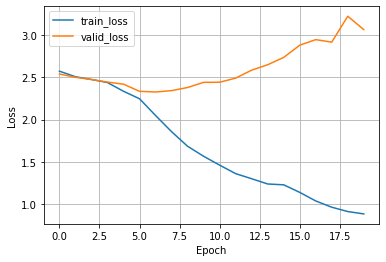

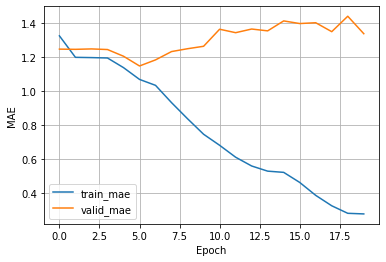

In [15]:
import pandas as pd


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_mae", "valid_mae"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='MAE')

- As we can see from the loss plot above, the model starts overfitting pretty quickly. Based on the MAE plot, we can see that the best model, based on the validation set MAE, may be around epoch 5.
- The `trainer` saved this model automatically for us, we which we can load from the checkpoint via the `ckpt_path='best'` argument; below we use the `trainer` instance to evaluate the best model on the test set:

In [16]:
trainer.test(model=lightning_model, dataloaders=test_loader, ckpt_path='best')

Restoring states from the checkpoint path at logs/rnn-coral-mnist/version_1/checkpoints/epoch=5-step=113.ckpt
Loaded model weights from checkpoint at logs/rnn-coral-mnist/version_1/checkpoints/epoch=5-step=113.ckpt


Testing: 100%|████████████████████████████████████| 6/6 [00:02<00:00,  1.95it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 1.1192857027053833}
--------------------------------------------------------------------------------
Testing: 100%|████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]


[{'test_mae': 1.1192857027053833}]

## Predicting labels of new data

- You can use the `trainer.predict` method on a new `DataLoader` or `DataModule` to apply the model to new data.
- Alternatively, you can also manually load the best model from a checkpoint as shown below:

In [17]:
path = f'{trainer.logger.log_dir}/checkpoints/epoch=5-step=113.ckpt'

lightning_model = LightningRNN.load_from_checkpoint(path)

- Note that our `RNN`, which is passed to `LightningRNN` requires input arguments. However, this is automatically being taken care of since we used `self.save_hyperparameters()` in `LightningRNN`'s `__init__` method.
- Now, below is an example applying the model manually. Here, pretend that the `test_dataloader` is a new data loader.

In [19]:
all_predicted_labels = []
for batch in test_loader:
    features, text_length = batch.TEXT_COLUMN_NAME
    logits = lightning_model.model(features, text_length)
    probas = torch.sigmoid(logits)
    predicted_labels = proba_to_label(probas)
    all_predicted_labels.append(predicted_labels)
    
all_predicted_labels = torch.cat(all_predicted_labels)
all_predicted_labels[:5]

tensor([0, 0, 0, 4, 4])